In [1]:
%pip install joblib==1.4.2

import sys
sys.path.append('./code')
sys.path.append('./data')

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from clustering import *
from sklearn.metrics import * 

from sklearn.metrics import ConfusionMatrixDisplay

np.random.seed(1)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.linewidth'] = 1.25

#modified from Kausik et al's code

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import joblib
print(joblib.__version__)

1.4.2


In [3]:
nGenres=100
genres = pd.read_csv('data/Lastfm-ArtistTags2007/tags.txt', header=None)[0].values[:nGenres]
genres = pd.DataFrame([genre.split()[0] for genre in genres], 
             index = [' '.join(genre.split()[1:]) for genre in genres],
            columns = ['count'])
genres.head()

,count
rock,440854
seen live,343901
indie,277747
alternative,245259
metal,184491


In [4]:
users = pd.read_csv("data/lastfm-dataset-1K/userid-profile.tsv", sep="\t")
users.head()

,#id,gender,age,country,registered
0,user_000001,m,NaN,Japan,"Aug 13, 2006"
1,user_000002,f,NaN,Peru,"Feb 24, 2006"
2,user_000003,m,22.0,United States,"Oct 30, 2005"
3,user_000004,f,NaN,NaN,"Apr 26, 2006"
4,user_000005,m,NaN,Bulgaria,"Jun 29, 2006"


In [5]:
lastfm = pd.read_csv("data/lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv", sep="\t", 
           header=None, on_bad_lines='skip')
lastfm.columns = ['userid', 'timestamp', 'artistid', 'artistname', 'trackid', 'trackname']
nTopUsers=10
topusers = lastfm.groupby('userid').size().sort_values()[-nTopUsers:]
lastfm = lastfm[[user in topusers for user in lastfm['userid']]]
lastfm.timestamp = pd.to_datetime(lastfm['timestamp'])

In [6]:
tags = pd.read_table('data/Lastfm-ArtistTags2007/ArtistTags.dat', sep="<sep>", header=None, on_bad_lines='skip')
tags.columns = ['artistid', 'artistname', 'tagname', 'rawtagcount']
tags = tags[[tag in genres.index for tag in tags['tagname']]]
# there are multiple tags/genres assigned to each artist.
#  for simplicity, pick the tag/genre most associated with each artist
#  by ranking by raw tag count and picking the first
tags = tags[tags.groupby(['artistid', 'artistname'])['rawtagcount'].rank(method='first', ascending=False) <= 1]

/tmp/cemiles/31573642/ipykernel_3981363/2105939917.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tags = pd.read_table('data/Lastfm-ArtistTags2007/ArtistTags.dat', sep="<sep>", header=None, on_bad_lines='skip')


In [7]:
dataset = lastfm.merge(tags, on='artistid').sort_values(['userid', 'timestamp'])[['userid', 'timestamp', 'tagname']].reset_index()
# assigning numbers to genres. doing so by ranking genres by how popular they are
tagdict = dict(zip(genres.index.values, np.arange(len(genres))))
dataset['tagnum'] = dataset['tagname'].replace(tagdict)
# for some reason, gupta et al only consider the transitions that change genre
#  we do so here
keeps = (dataset.tagname != dataset.tagname.shift()) * (dataset.userid == dataset.userid.shift())
keeps[0] = True
dataset = dataset[keeps]

/opt/apps/anaconda/2022.05/lib/python3.9/site-packages/pandas/core/computation/expressions.py:214: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  warnings.warn(


In [8]:
nStates = len(genres)
nActions = 1
K = len(topusers)

In [9]:
trajLengths = [20,30, 40,50,60,70,80,90,100]
nTrials=10
randscores = np.zeros([len(trajLengths),nTrials])
adjrandscores = np.zeros([len(trajLengths),nTrials])
errs = np.zeros([len(trajLengths),nTrials])

In [10]:
for s in range(len(trajLengths)):
    for ss in range(nTrials):
        horizon = trajLengths[s]
        N = int(75*horizon) # fixed number of trajectories 
        numTrajPerK = int(N/horizon)
        nTraj = numTrajPerK * K
        #gupta et al only keep first 3000 transitions
        #building array of one hots

        #shuffling dataset
        dataset = dataset.sample(frac=1).reset_index(drop=True)
        dataset = dataset.sort_values(by='timestamp')    

        start_i = 0# np.random.randint(0,3*N)
        states = np.array([dataset[dataset.userid == user].tagnum.values[start_i:N+start_i] for user in topusers.index.sort_values()])


        #splitting into trajectories of length horizon
        states = np.array(np.split(states, numTrajPerK, axis=1)).transpose(1,0,2)

        #why concatenate? want 0,..,0,1...,1,...,9...,9
        labels = np.concatenate([np.ones(numTrajPerK)*k for k in range(K)])
        states = np.concatenate(states)
        
        nEM = 250
        nClustMax=10
        Xt=states
        nStates=nGenres

        zHat, muHat, qHat, pHat, steps, logL =  doVEMmultiPar(Xt, nClustMax, nStates, nEM=nEM)

        trueLabels = labels.astype('int64')
        
        best_assignment, zHat_c, qHat_c, muHat_c, pHat_c = find_best_clustermatch(trueLabels.T, zHat, muHat, qHat, pHat)  
        predictLabels = zHat_c.argmax(axis=1)

        adj_rand = adjusted_rand_score(trueLabels,predictLabels)
        rand = rand_score(trueLabels,predictLabels)
        err=1.0-sum(trueLabels==predictLabels)/len(predictLabels)
        randscores[s,ss] = rand
        adjrandscores[s,ss]=adj_rand
        errs[s,ss]=err


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   49.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   48.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   46.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | 

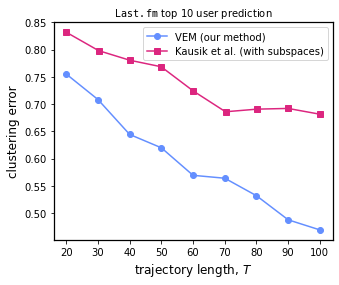

In [11]:
#plt.plot(trajLengths,np.mean(errs,axis=1))
colors = np.array(['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000'])
plt.figure(figsize=(5,4))
plt.plot(trajLengths,np.mean(errs,axis=1),marker='o',color=colors[0]) # take best of our attempts, also note there isn't much variance in acc

plt.xlabel('trajectory length, $T$',fontsize=12)
plt.ylabel('clustering error',fontsize=12)
plt.title('${\\tt Last.fm}$ top 10 user prediction',fontsize=10)
# x/y values scraped from Kausik's figure 
plt.plot([20, 30.2009702009702, 40.06930006930007, 49.937629937629936, 60.02772002772003, 70.22869022869023, 80.20790020790021, 89.96534996534996, 100], [0.8319852941176471, 0.7982077205882353, 0.7805147058823529, 0.7686121323529412, 0.72421875, 0.6859375000000001, 0.6907628676470589, 0.6920496323529413, 0.6814338235294118],marker='s',color=colors[2])
plt.legend(['VEM (our method)','Kausik et al. (with subspaces)'])
plt.savefig('figs/lastfm_10perform.pdf')

In [12]:
with open('temp/lastfm10_sweep.npy', 'wb') as f:
    np.save(f,errs)
    np.save(f,trajLengths)